# Práctica Guiada: Manifold Learning

## Ejemplo 1. IsoMaps en detección de caras

Manifold learning es usado habitualmente para entender la relación entre datos de alta dimensionalidad. Un caso muy común es el análisis de imágenes: por ejemplo, un set de imágenes con 1000 pixels cada una puede ser pensado como una colección de puntos en 1000 dimensiones -el brillo de cada pixel en cada imágen define la coordenada en esa dimensión.

Vamos a aplicar IsoMap sobre un [dataset de imágenes de caras](http://vis-www.cs.umass.edu/lfw/). El dataset se llama "Labeled Faces in the Wild" y es una base de datos para trabajar con reconcimiento de rostors. Contiene alrededor de 13000 imágenes recolectadas de la web. Cada cara fue taggeada con el nombre de la persona.



In [1]:
#from sklearn.datasets import fetch_lfw_people
#faces = fetch_lfw_people(min_faces_per_person=30)
#faces.data.shape

#import joblib
#joblib.dump(faces, "./faces_p2.dump")

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

import joblib
faces = joblib.load("../Data/faces_p2.dump")
faces.target_names

from sklearn.decomposition import PCA
from sklearn.manifold import Isomap, LocallyLinearEmbedding, MDS

In [2]:
faces.target_names

array([b'Alejandro Toledo', b'Alvaro Uribe', b'Andre Agassi',
       b'Ariel Sharon', b'Arnold Schwarzenegger', b'Colin Powell',
       b'David Beckham', b'Donald Rumsfeld', b'George W Bush',
       b'Gerhard Schroeder', b'Gloria Macapagal Arroyo',
       b'Guillermo Coria', b'Hans Blix', b'Hugo Chavez', b'Jacques Chirac',
       b'Jean Chretien', b'Jennifer Capriati', b'John Ashcroft',
       b'John Negroponte', b'Junichiro Koizumi', b'Kofi Annan',
       b'Laura Bush', b'Lleyton Hewitt', b'Luiz Inacio Lula da Silva',
       b'Megawati Sukarnoputri', b'Nestor Kirchner',
       b'Recep Tayyip Erdogan', b'Roh Moo-hyun', b'Serena Williams',
       b'Silvio Berlusconi', b'Tom Ridge', b'Tony Blair', b'Vicente Fox',
       b'Vladimir Putin'], 
      dtype='|S25')

Tenemos alrededor 2.370 imágenes cada una con 2.914 pixels. En otras palabras, podemos pensar estas imágenes como puntos en un espacio de 2.914 dimesiones.

Hagamos una visualización rápida de algunas imágenes para ver con qué estamos trabajando.

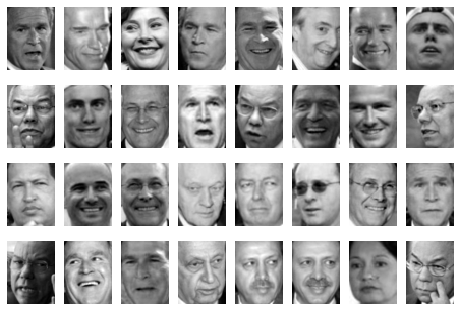

In [3]:
fig, ax = plt.subplots(4, 8, subplot_kw=dict(xticks=[], yticks=[]))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='gray')

Nos gustaría poder representar estas imágenes (que están en un espacio 2.914-dimensional) en un "embedding" de baja dimensionalidad para poder aprender las relaciones fundamentales entre las imágenes. Una primera forma simple de comenzar sería computar en PCA y examinar la razón de variancia explicada, que nos daría una idea de cuántas features lineales se requieren para poder describir estos datos.

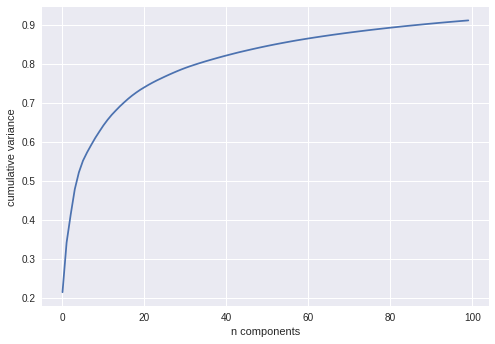

In [4]:
model_pca = PCA(100).fit(faces.data)
plt.plot(np.cumsum(model_pca.explained_variance_ratio_))
plt.xlabel('n components')
plt.ylabel('cumulative variance')

Vemos que para este dataset alrededor de 100 componentes son necesarios para preservar el 90% de la varianza. Esto nos dice que, en principio, este dataset que es altamente multidimensional no puede ser descripto (linealmente) con pocos componentes. 

Cuando este es el caso, métodos de manifold learning no lineal como LLE o IsoMap pueden ser de mucha ayuda. Podemos computar IsoMap en estas imágenes de la siguiente forma:

In [5]:
model_iso = Isomap(n_components=2)
proj_iso = model_iso.fit_transform(faces.data)
proj_iso.shape

(2370, 2)

In [6]:
model_lle = LocallyLinearEmbedding(n_neighbors=90, n_components=2, method='modified',
                               eigen_solver='dense')
proj_lle = model_lle.fit_transform(faces.data)
proj_lle.shape


(2370, 2)

El output es una proyección bidensional de todas las imágenes de input. Para tener una mejor idea de qué nos está diciendo esta proyección, definamos una función que va a plotear thumbnails de las imágenes en las coordenadas de la proyección:

In [7]:
from matplotlib import offsetbox

def plot_components(data, model, images=None, ax=None,
                    thumb_frac=0.05, cmap='gray'):
    ax = ax or plt.gca()
    
    proj = model.fit_transform(data)
    ax.plot(proj[:, 0], proj[:, 1], '.k')
    
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # don't show points that are too close
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap),
                                      proj[i])
            ax.add_artist(imagebox)

Llamando a esta función podemos ver los resultados:

##### IsoMap

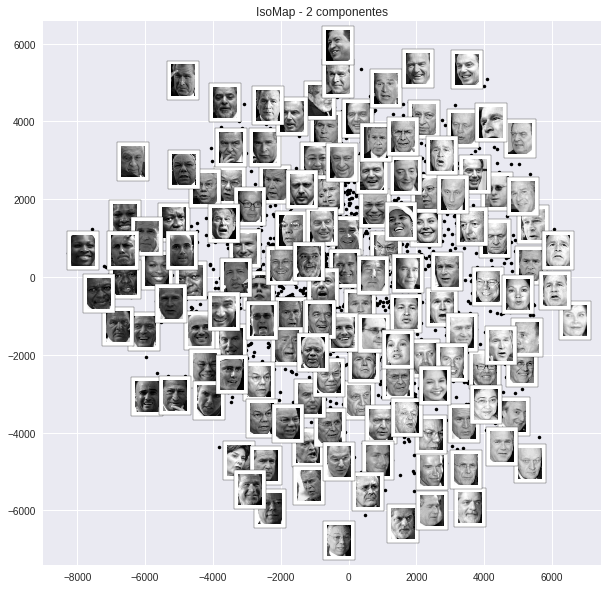

In [8]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_components(faces.data,
                model=Isomap(n_components=2),
                images=faces.images[:, ::2, ::2])
plt.title('IsoMap - 2 componentes')

El resultado es interesante: las primeras dos dimensiones del IsoMap parecen describir dos características globales de las imágenes.
    
  * el brillo parece decrecer de izquierda a derecha
  * la orientación de la cara parece variar de arriba a abajo

Esto nos da una idea visual de algunos de los features fundamentales en los datos.

Luego, podríamos tratar de clasificar los datos (usando algunos de los métodos que hemos visto) tomando como features las dimensiones del IsoMap.

### Repitiendo el ejercicio con otros métodos de Manifold Learning

#### PCA

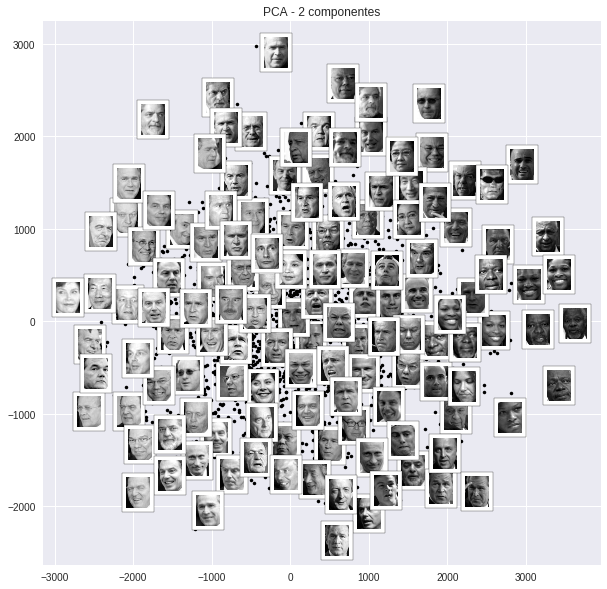

In [9]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_components(faces.data,
                model=PCA(n_components=2),
                images=faces.images[:, ::2, ::2])
plt.title('PCA - 2 componentes')

#### MDS 

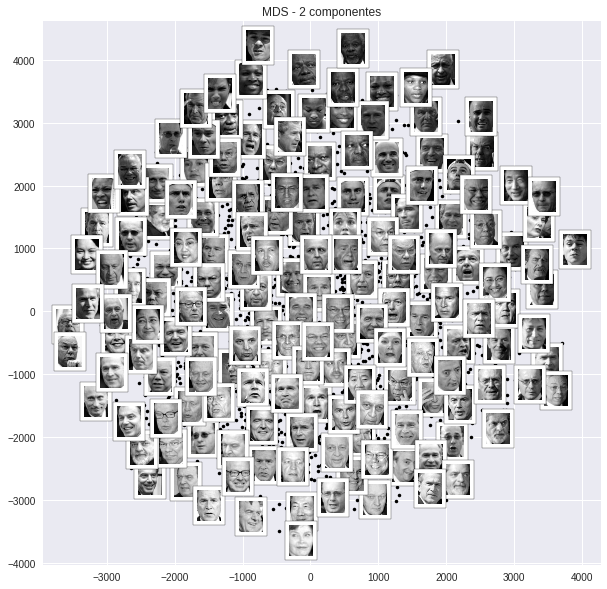

In [10]:
from sklearn.manifold import MDS
fig, ax = plt.subplots(figsize=(10, 10))
plot_components(faces.data,
                model=MDS(n_components=2),
                images=faces.images[:, ::2, ::2])
plt.title('MDS - 2 componentes')

#### LLE

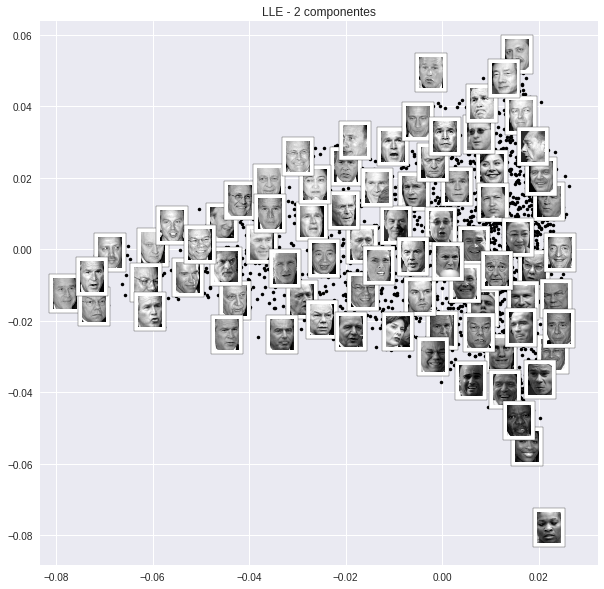

In [11]:
fig, ax = plt.subplots(figsize=(10, 10))
plot_components(faces.data,
                model=LocallyLinearEmbedding(n_components=2),
                images=faces.images[:, ::2, ::2])
plt.title('LLE - 2 componentes')

## Ejemplo 2. Visualizando estructuras en dígitos

Veamos otro ejemplo para manifold learning. Usaremos el dataset de díginos MNIST. Es similar al que usamos en el LAB sobre Random Forest, pero tiene más pixels por imágen. Puede ser descargado de http://mldata.org/ con la utilidad de sklearn.

In [13]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
mnist.data.shape

(70000, 784)

El dataset consiste en 70.000 imágenes cada una de 784 pixels (las imágenes son de 28x28). Veamos las primeras imágenes.

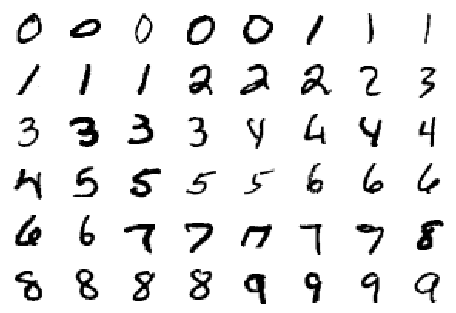

In [14]:
fig, ax = plt.subplots(6, 8, subplot_kw=dict(xticks=[], yticks=[]))
for i, axi in enumerate(ax.flat):
    axi.imshow(mnist.data[1250 * i].reshape(28, 28), cmap='gray_r')

Esto nos da una idea de la variedad de estilos manuscritos en el dataset.

Vamos a computar una projección en base a un método de manifold learning. Para acelerar los tiempos de cómputo solamente vamos a usar $\frac{1}{30}$ de los datos (que implicaría alrededor de 2000 puntos). Recordemos que, en general, manifold learning no "escala" bien con la cantidad de datos. En general, se considera que una cantidad de observaciones en el orden de los miles es un buen número para realizar las primeras exploraciones sobre los datos.

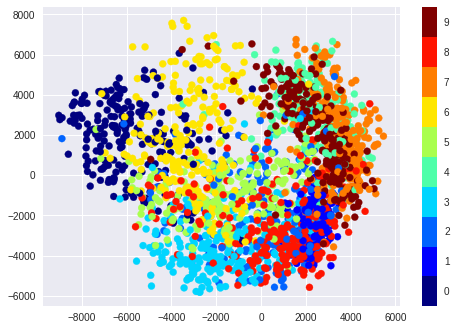

In [15]:
# usar solamente 1/30 de los datos
data = mnist.data[::30]
target = mnist.target[::30]

model = Isomap(n_components=2)
proj = model.fit_transform(data)
plt.scatter(proj[:, 0], proj[:, 1], c=target, cmap=plt.cm.get_cmap('jet', 10))
plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5);

El scatter plot resultante muestra algunas de las relaciones entre los datapoints... sin embargo, está un tanto amontonado. Podemos ganar una mayor comprensión analizando solamente un número a la vez:

In [16]:
# Elegir 1/4 de los 1's
d=1
data = mnist.data[mnist.target == d][::4]

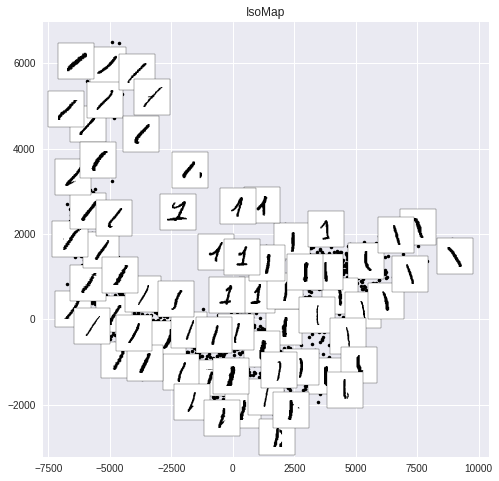

In [17]:
from sklearn.manifold import Isomap
fig, ax = plt.subplots(figsize=(8, 8))
model = Isomap(n_neighbors=5, n_components=2, eigen_solver='dense')
plot_components(data, model, images=data.reshape((-1, 28, 28)),
                ax=ax, thumb_frac=0.05, cmap='gray_r')
plt.title('IsoMap')

El resultado nos da una idea de la variedad de formas que el número "1" puede tener en el dataset. Los datos caen en una curva en el espacio proyectado que parece trazar la orientación del dígito. A medida que se sube en gráfico, aparecen unos que tienen "sombreros" o bases, aunque están muy dispersos en el dataset. La proyección nos deja identificar outliers con problemas en los datos: por ejemplo, pedazos de los dígitos vecinos que se "meten" en las imágenes extraídas.

Ahora bien, este análisis puede no ser necesariamente útil en la tarea de clasificación de dígitos pero nos ayuda a tener una mejor comprensión de los datos antes de seguir adelante en el proceso. Por eso, en las etapas de preprocesamiento y análisis este tipo de herramientas parecen mostrar su mayor potencialidad.

#### Comparar con el resto de los métodos vistos...

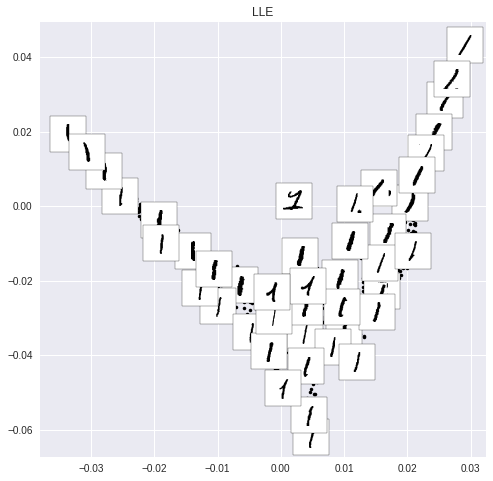

In [18]:
fig, ax = plt.subplots(figsize=(8, 8))
model = LocallyLinearEmbedding(n_components=2,n_jobs=4)
plot_components(data, model, images=data.reshape((-1, 28, 28)),
                ax=ax, thumb_frac=0.05, cmap='gray_r')
plt.title('LLE')

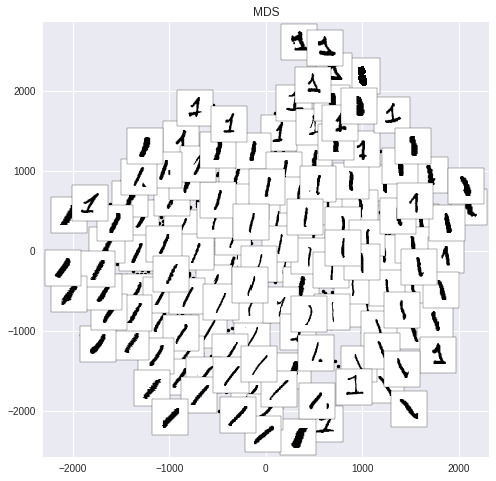

In [19]:
fig, ax = plt.subplots(figsize=(8, 8))
model = MDS(n_components=2, n_jobs=4)
plot_components(data, model, images=data.reshape((-1, 28, 28)),
                ax=ax, thumb_frac=0.05, cmap='gray_r')
plt.title('MDS')

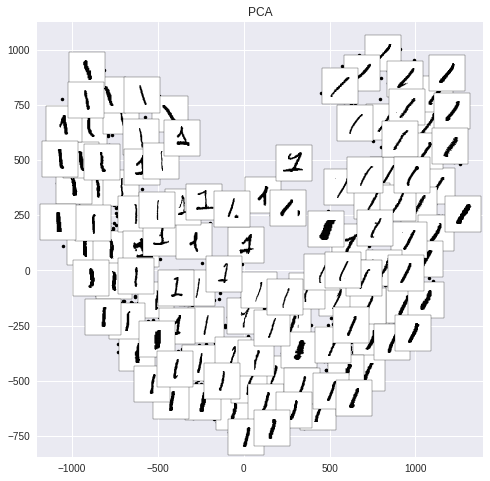

In [22]:
fig, ax = plt.subplots(figsize=(8, 8))
model = PCA(n_components=2)
plot_components(data, model, images=data.reshape((-1, 28, 28)),
                ax=ax, thumb_frac=0.05, cmap='gray_r')
plt.title('PCA')